In [ ]:
import requests
import json
import time
import os
import math
from datetime import datetime, timedelta

from tqdm import tqdm

"""Функция, которая записывает в vacancies полученные данные по запросу к API "Работа России""""

def getDay(modifiedFrom: datetime):

    modifiedTo = modifiedFrom + timedelta(hours=1)
    params = {
        'modifiedFrom': f"{modifiedFrom.strftime('%Y-%m-%d')}T{modifiedFrom.hour}:00:00Z",
        'modifiedTo': f"{modifiedTo.strftime('%Y-%m-%d')}T{modifiedTo.hour}:00:00Z",
        'limit': 100,
        'offset': 0
    }

    req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
    data = json.loads(req.content.decode())
    req.close()
    if data['results']:
        vacancies = data['results']['vacancies']
    else:
        vacancies = []
    total = int(data['meta']['total'])
    if total > 10000:
        raise Exception('total more than 10000')
    for _ in tqdm(range(math.ceil(total // 100))):
        time.sleep(0.1)
        params['offset'] += 1
        req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
        data = json.loads(req.content.decode())
        req.close()
        if data['results']:
            vacancies += data['results']['vacancies']
    return vacancies

# cобираем данные с 10 марта 2022 года (по дате раньше API не выдает данные), 
# итерируясь по 1 часу из-за ограничения на количество данных по 10000 записей за запрос

start_time = datetime(year=2022, month=03, day=10)
end_time = datetime(year=2022, month=5, day=1)

vacancies = []

while start_time < end_time:
    try:
        vacancies += getDay(start_time)
    except Exception as e:
        print(e)
        with open('backup.json', 'w') as file:
            json.dump(vacancies, file)
            break
    start_time += timedelta(hours=1)
    print(start_time)

In [ ]:
"""Сохраняем данные в json-файл"""
with open('full_data.json', 'w') as file:
    json.dump(vacancies, file)

In [ ]:
"""Преобразуем json-файл в датафрейм"""
import pandas as pd
import json

with open('full_data.json', 'r') as file:
    df = pd.json_normalize(json.load(file))

In [27]:
import pandas as pd
import json

with open('backup.json', 'r') as file1:
    df1 = pd.json_normalize(json.load(file1))

with open('full_data08.json', 'r') as file2:
    df2 = pd.json_normalize(json.load(file2))

# with open('third_data.json', 'r') as file3:
#     df3 = pd.json_normalize(json.load(file3))

df = pd.concat([df1, df2], sort = False, axis = 0)
# df = pd.concat([df4, df3], sort = False, axis = 0)

In [28]:
df.drop_duplicates(subset=['vacancy.id'],keep='first',inplace=True)

In [29]:
df_result = df.reset_index().drop(columns = ['index'],axis = 1)
# df_result.to_csv("cleaned_data.csv")

In [15]:
df_result["vacancy.category.specialisation"].value_counts()

Производство                                                        58587
Образование, наука                                                  19500
Здравоохранение и социальное обеспечение                            18887
Продажи, закупки, снабжение, торговля                               12171
Консалтинг, стратегическое развитие, управление                     11237
Пищевая промышленность                                               9944
Транспорт, автобизнес, логистика, склад, ВЭД                         9472
Строительство, ремонт, стройматериалы, недвижимость                  6903
Юриспруденция                                                        4753
ЖКХ, эксплуатация                                                    4182
Сельское хозяйство, экология, ветеринария                            3900
Банки, кредит, страхование, пенсионное обеспечение                   2826
Металлургия, металлообработка                                        2461
Искусство, культура и развлечения     

In [17]:
try:
    df_result["vacancy.creation-date"].astype('datetime64')
except:
    None

In [18]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183394 entries, 0 to 183393
Data columns (total 35 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   vacancy.id                            183394 non-null  object
 1   vacancy.source                        183394 non-null  object
 2   vacancy.region.region_code            183394 non-null  object
 3   vacancy.region.name                   183394 non-null  object
 4   vacancy.company.ogrn                  183335 non-null  object
 5   vacancy.company.companycode           183394 non-null  object
 6   vacancy.company.hr-agency             183394 non-null  bool  
 7   vacancy.company.phone                 154072 non-null  object
 8   vacancy.company.inn                   182753 non-null  object
 9   vacancy.company.name                  183366 non-null  object
 10  vacancy.company.kpp                   160339 non-null  object
 11  vacancy.compa

In [50]:
"""Выбираем нужные специализации"""

df_filtered = df[(df["vacancy.category.specialisation"] == "Информационные технологии, телекоммуникации, связь") 
| (df["vacancy.category.specialisation"] == "Искусство, культура и развлечения") | 
(df["vacancy.category.specialisation"] == "Безопасность, службы охраны") | 
(df["vacancy.category.specialisation"] == "Государственная служба, некоммерческие организации")]
df_filtered

,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,vacancy.company.name,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
66,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1025401504039,http://nokkii.ru/,1025401504039,False,5404131424,Государственное автономное профессиональное об...,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
115,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025202210538,NaN,1025202210538,False,5201004100,"Отдел по вопросам культуры, спорта и молодежи ...",...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
141,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1034205018110,http://lad-dva.ru,1034205018110,False,4206002915,"ООО ""КОМПАНИЯ ЛАД-ДВА""",...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
191,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1023600511448,NaN,1023600511448,False,3662180590,"ОВО ПО ПАНИНСКОМУ РАЙОНУ-ФИЛИАЛ ФГКУ ""УВО ВНГ ...",...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
243,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1022304246502,NaN,1022304246502,False,2340015390,ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ КРАСНОДАРС...,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359290,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1021801509828,NaN,1021801509828,False,1833000800,"КПОУ УР ""Удмуртский республиканский колледж ку...",...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
359309,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
359310,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
359323,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1115543001056,NaN,1115543001056,False,5519200201,"БУ ЛМР ""ЦКИ ЛМР""",...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


In [186]:
df_filtered["vacancy.category.specialisation"].value_counts()

Информационные технологии, телекоммуникации, связь    8624
Государственная служба, некоммерческие организации    7450
Искусство, культура и развлечения                     7440
Безопасность, службы охраны                           4928
Name: vacancy.category.specialisation, dtype: int64

In [51]:
df_filtered = df_filtered.reset_index().drop(columns = ['index'])

In [30]:
"""Преобразуем время в формат datetime"""
from datetime import datetime

def change_date(x):
    try:
        date = datetime.strptime(x, "%Y-%m-%d")
        
    except Exception as e: # нам известно о двух ошибках в записи времени
         # если не получилось преобразовать в datetime, то исправляем эти две ошибки 
        if x == "333322-03-11":
            return datetime.strptime('2022-03-11', "%Y-%m-%d")
        return datetime.strptime('2022-03-28', "%Y-%m-%d")
        
    return date
    
df_result["vacancy.creation-date"] = df_result["vacancy.creation-date"].apply(change_date)

In [33]:
df_result

,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.phone,vacancy.company.inn,vacancy.company.name,...,vacancy.company.site,vacancy.company.email,vacancy.requirement.education,vacancy.requirement.qualification,vacancy.term.text,vacancy.company.logo,vacancy.company.fax,vacancy.social_protected,vacancy.company.code_industry_branch,vacancy.category.industry
0,f32fd635-d283-11ec-aa72-550ed7335bbe,Работодатель,7400000000000,Челябинская область,1027402929982,1027402929982,False,+7(351) 280-01-71,7451054361,Муниципальное автономное общеобразовательное у...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f5bd5df1-1626-11ed-98cd-dbfed3997e57,INTERNET_RESOURCE,3400000000000,Волгоградская область,5147746474134,5147746474134,False,+7(926)3270262,7709969870,"ООО ""РДВ-СОФТ""",...,https://www.rabota.ru/,a.shmakova@rabota.ru,Среднее,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f5c6d3d1-1626-11ed-98cd-dbfed3997e57,INTERNET_RESOURCE,3400000000000,Волгоградская область,5147746474134,5147746474134,False,+7(926)3270262,7709969870,"ООО ""РДВ-СОФТ""",...,https://www.rabota.ru/,a.shmakova@rabota.ru,Среднее,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f65d4771-1626-11ed-98cd-dbfed3997e57,INTERNET_RESOURCE,5500000000000,Омская область,5147746474134,5147746474134,False,+7(926)3270262,7709969870,"ООО ""РДВ-СОФТ""",...,https://www.rabota.ru/,a.shmakova@rabota.ru,Среднее,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9564cf12-1fef-11ed-aeb3-93f7cc862eb6,Служба занятости,2200000000000,Алтайский край,1022202523837,1022202523837,False,+7(38556)21927,2265001797,АДМИНИСТРАЦИЯ ПОСПЕЛИХИНСКОГО РАЙОНА АЛТАЙСКОГ...,...,NaN,arnpsp@mail.ru,Высшее,Сохраненное рабочее место<br/>Главный специали...,ЗдравохранениеПредоставление служ.жильяСоциаль...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183389,0a00a9c2-07a4-11ed-bddd-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1182375097750,1182375097750,False,+7(918)9817134,2372024439,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АРМА...",...,NaN,uprkom8@mail.ru,Среднее,Уборщик мест общего пользования в многоквартир...,Социальный пакет,NaN,NaN,NaN,NaN,NaN
183390,66458102-ac8d-11ec-9aad-bf2cfe8c828d,Служба занятости,7600000000000,Ярославская область,1087627000031,1087627000031,False,+7(4852)679665,7627032220,"АО ""Племзавод Ярославка""",...,http://Сайт,yaroslawka@mail.ru,Среднее,-фасовщик<br/>Ответственность,Социальный пакетРабота по граф. смен. 2/2. Об...,NaN,NaN,NaN,NaN,NaN
183391,664a3bf2-ac8d-11ec-9aad-bf2cfe8c828d,Служба занятости,7600000000000,Ярославская область,1087627000031,1087627000031,False,+7(4852)679665,7627032220,"АО ""Племзавод Ярославка""",...,http://Сайт,yaroslawka@mail.ru,Среднее,животноводческого отделения<br/>Ответственность,Социальный пакетПредоставление жильяНормальная...,NaN,NaN,NaN,NaN,NaN
183392,23930fc0-b5f8-11ec-9aad-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1160105050368,1160105050368,False,+7(928)4165887,0107030181,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ГЕРОН""",...,NaN,geron.ooo@yandex.ru,Среднее профессиональное,Ответственность<br/>Дисциплинированность<br/>В...,Социальный пакетПредоставление спец.одеждыСист...,NaN,NaN,NaN,NaN,NaN


In [32]:
"""Валидируем корректность даты"""

def clean_date(x):
    if x > datetime.strptime('2022-08-24', "%Y-%m-%d"):
        return None
    elif x < datetime.strptime('2016-01-01', "%Y-%m-%d"):
        return None
    return x

df_result["vacancy.creation-date"] = df_result["vacancy.creation-date"].apply(clean_date)

In [24]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183394 entries, 0 to 183393
Data columns (total 35 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   vacancy.id                            183394 non-null  object        
 1   vacancy.source                        183394 non-null  object        
 2   vacancy.region.region_code            183394 non-null  object        
 3   vacancy.region.name                   183394 non-null  object        
 4   vacancy.company.ogrn                  183335 non-null  object        
 5   vacancy.company.companycode           183394 non-null  object        
 6   vacancy.company.hr-agency             183394 non-null  bool          
 7   vacancy.company.phone                 154072 non-null  object        
 8   vacancy.company.inn                   182753 non-null  object        
 9   vacancy.company.name                  183366 non-null  obje

In [57]:
first_date = datetime.strptime('2016-01-01', "%Y-%m-%d") 
end_date = datetime.strptime('2022-05-01', "%Y-%m-%d")
df_result = df_filtered.loc[(df_filtered["vacancy.creation-date"] < end_date) & (df_filtered["vacancy.creation-date"] > first_date)]
df_result

,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,vacancy.company.name,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
0,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1025401504039,http://nokkii.ru/,1025401504039,False,5404131424,Государственное автономное профессиональное об...,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
1,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025202210538,NaN,1025202210538,False,5201004100,"Отдел по вопросам культуры, спорта и молодежи ...",...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
2,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1034205018110,http://lad-dva.ru,1034205018110,False,4206002915,"ООО ""КОМПАНИЯ ЛАД-ДВА""",...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
3,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1023600511448,NaN,1023600511448,False,3662180590,"ОВО ПО ПАНИНСКОМУ РАЙОНУ-ФИЛИАЛ ФГКУ ""УВО ВНГ ...",...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
4,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1022304246502,NaN,1022304246502,False,2340015390,ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ КРАСНОДАРС...,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28437,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1021801509828,NaN,1021801509828,False,1833000800,"КПОУ УР ""Удмуртский республиканский колледж ку...",...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
28438,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28439,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28440,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1115543001056,NaN,1115543001056,False,5519200201,"БУ ЛМР ""ЦКИ ЛМР""",...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


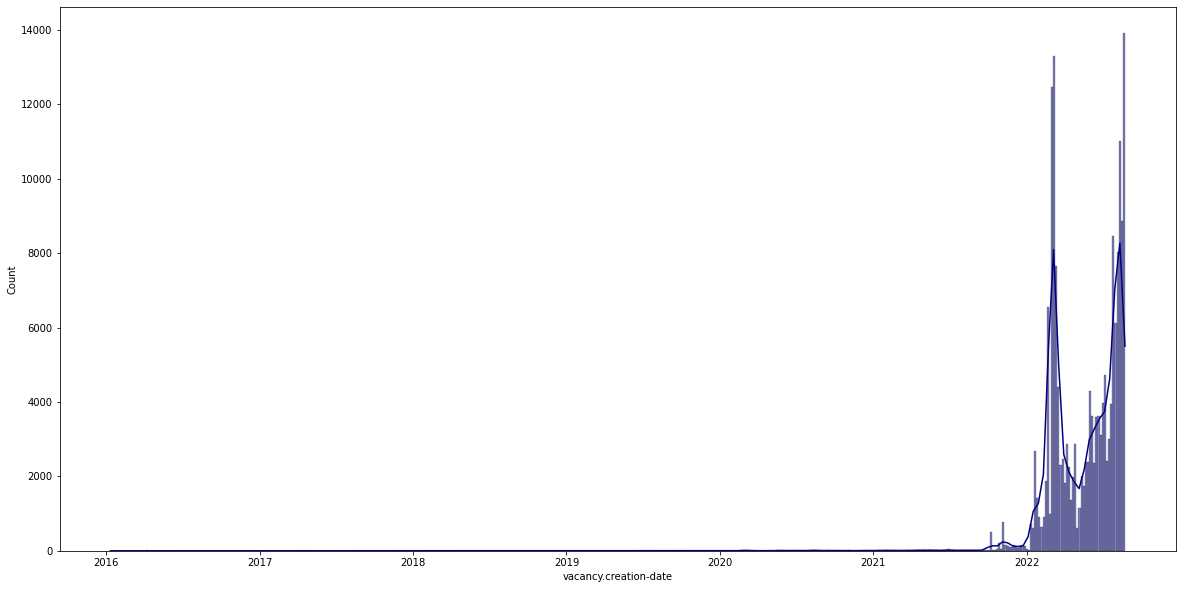

In [34]:
"""Визуализируем распредение вакансий по времени создания"""
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.histplot(data=df_result, x='vacancy.creation-date', color = 'navy', kde = True)
plt.show()

In [35]:
# df_result.to_json('result_data.json')
df_result.to_csv('result_data.csv')

In [5]:
import pandas as pd

df = pd.read_csv("result_data.csv")
df

/var/folders/pf/sj5w0_zs1fs2qhqbvvcnn2500000gn/T/ipykernel_30021/675258569.py:3: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("result_data.csv")


,Unnamed: 0,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
0,0,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1.025402e+12,http://nokkii.ru/,1025401504039,False,5.404131e+09,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
1,1,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025202e+12,NaN,1025202210538,False,5.201004e+09,...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
2,2,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1.034205e+12,http://lad-dva.ru,1034205018110,False,4.206003e+09,...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
3,3,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1.023601e+12,NaN,1023600511448,False,3.662181e+09,...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
4,4,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1.022304e+12,NaN,1022304246502,False,2.340015e+09,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28361,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1.021802e+12,NaN,1021801509828,False,1.833001e+09,...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
28362,28362,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28363,28363,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28364,28364,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1.115543e+12,NaN,1115543001056,False,5.519200e+09,...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


In [10]:
df

,Unnamed: 0,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
0,0,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1.025402e+12,http://nokkii.ru/,1025401504039,False,5.404131e+09,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
1,1,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025202e+12,NaN,1025202210538,False,5.201004e+09,...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
2,2,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1.034205e+12,http://lad-dva.ru,1034205018110,False,4.206003e+09,...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
3,3,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1.023601e+12,NaN,1023600511448,False,3.662181e+09,...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
4,4,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1.022304e+12,NaN,1022304246502,False,2.340015e+09,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28361,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1.021802e+12,NaN,1021801509828,False,1.833001e+09,...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
28362,28362,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28363,28363,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28364,28364,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1.115543e+12,NaN,1115543001056,False,5.519200e+09,...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


In [9]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28366 entries, 0 to 28365
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            28366 non-null  int64         
 1   vacancy.id                            28366 non-null  object        
 2   vacancy.source                        28366 non-null  object        
 3   vacancy.region.region_code            28366 non-null  int64         
 4   vacancy.region.name                   28366 non-null  object        
 5   vacancy.company.ogrn                  28353 non-null  float64       
 6   vacancy.company.site                  6925 non-null   object        
 7   vacancy.company.companycode           28363 non-null  object        
 8   vacancy.company.hr-agency             28363 non-null  object        
 9   vacancy.company.inn                   28325 non-null  float64       
 10

In [8]:
df["vacancy.creation-date"] = df["vacancy.creation-date"].astype("datetime64")

In [11]:
df_first_period = df[(df["vacancy.creation-date"] >= "2022-01-01") & (df["vacancy.creation-date"] < "2022-02-25")]

In [13]:
df_first_period.to_csv("first_period.csv")

In [15]:
df_second_period = df[(df["vacancy.creation-date"] >= "2022-02-25") & (df["vacancy.creation-date"] < "2022-04-23")]

In [16]:
df_second_period

,Unnamed: 0,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
0,0,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1.025402e+12,http://nokkii.ru/,1025401504039,False,5.404131e+09,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
1,1,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025202e+12,NaN,1025202210538,False,5.201004e+09,...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
2,2,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1.034205e+12,http://lad-dva.ru,1034205018110,False,4.206003e+09,...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
4,4,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1.022304e+12,NaN,1022304246502,False,2.340015e+09,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
6,6,35307332-9be0-11ec-add7-bf2cfe8c828d,Служба занятости,3800000000000,Иркутская область,3.163850e+14,NaN,316385000114745,False,3.826009e+11,...,"Социальный пакет0,25 ст. от 22224",«руб.»,0,+7(904)1349983,1@mail.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28361,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1.021802e+12,NaN,1021801509828,False,1.833001e+09,...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
28362,28362,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28363,28363,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1.025203e+12,NaN,1025203047385,False,5.260071e+09,...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28364,28364,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1.115543e+12,NaN,1115543001056,False,5.519200e+09,...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


In [17]:
df_second_period.to_csv("second_period.csv")